In [18]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons
from pymutspec.io import read_genbank_ref

from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error, r2_score
import tqdm

from utils import (
    amino_acid_codes, alphabet, cdn_spectrum_to_matrix, 
    nuc_spectrum_to_matrix, collect_possible_changes,
    get_equilibrium_probabilities, plot_exp_heatmap,
    prepare_aa_subst, plot_aa_eq_freqs, prepare_exp_aa_subst,
    calc_metrics,weighted_average_percentage_error
)

In [2]:
coda = CodonAnnotation(1)

## Load reference and calc amino acid freqs

In [3]:
from Bio import SeqIO
rec = next(SeqIO.parse("data/NC_045512.2.gb", "genbank"))

In [4]:
ref_df = pd.DataFrame([f.qualifiers for f in rec.features if f.type == "CDS"])
ref_df.drop(columns=["locus_tag", "ribosomal_slippage", "codon_start", 
                     "db_xref", 'gene_synonym'], inplace=True)
ref_df["gene"] = ref_df["gene"].apply(lambda x: x[0])
ref_df["product"] = ref_df["product"].apply(lambda x: x[0])
ref_df["protein_id"] = ref_df["protein_id"].apply(lambda x: x[0])
ref_df["translation"] = ref_df["translation"].apply(lambda x: x[0])
ref_df = ref_df[ref_df['product'] != 'ORF1a polyprotein']
ref_df.to_csv('./data/ref_proteins.csv', index=False)
ref_df

,gene,note,product,protein_id,translation
0,ORF1ab,[pp1ab; translated by -1 ribosomal frameshift],ORF1ab polyprotein,YP_009724389.1,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...
2,S,[structural protein; spike protein],surface glycoprotein,YP_009724390.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
3,ORF3a,NaN,ORF3a protein,YP_009724391.1,MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...
4,E,[ORF4; structural protein; E protein],envelope protein,YP_009724392.1,MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNI...
5,M,[ORF5; structural protein],membrane glycoprotein,YP_009724393.1,MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFL...
6,ORF6,NaN,ORF6 protein,YP_009724394.1,MFHLVDFQVTIAEILLIIMRTFKVSIWNLDYIINLIIKNLSKSLTE...
7,ORF7a,NaN,ORF7a protein,YP_009724395.1,MKIILFLALITLATCELYHYQECVRGTTVLLKEPCSSGTYEGNSPF...
8,ORF7b,NaN,ORF7b,YP_009725318.1,MIELSLIDFYLCFLAFLLFLVLIMLIIFWFSLELQDHNETCHA
9,ORF8,NaN,ORF8 protein,YP_009724396.1,MKFLVFLGIITTVAAFHQECSLQSCTQHQPYVVDDPCPIHFYSKWY...
10,N,[ORF9; structural protein],nucleocapsid phosphoprotein,YP_009724397.2,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...


In [5]:
aa_freqs_df = pd.DataFrame(ref_df.set_index('gene')['translation']\
                           .apply(Counter).to_dict()).T.fillna(0).astype(int)
aa_freqs_df.to_csv('./data/ref_aa_freqs.csv')
aa_freqs_df

,M,E,S,L,V,P,G,F,N,K,T,H,Q,R,D,A,C,Y,I,W
ORF1ab,168,340,456,668,598,274,412,349,384,434,527,145,239,244,389,487,226,335,343,78
S,14,48,99,108,97,58,82,77,88,61,97,17,62,42,62,79,40,54,76,12
ORF3a,4,11,22,30,25,12,14,14,8,11,24,8,9,6,13,13,7,17,21,6
E,1,2,8,14,13,2,1,5,5,2,4,0,0,3,1,4,3,4,3,0
M,4,7,15,35,12,5,14,11,11,7,13,5,4,14,6,19,4,9,20,7
ORF6,3,5,4,8,3,1,0,3,4,4,3,1,3,1,4,1,0,2,10,1
ORF7a,1,8,7,15,8,6,4,10,2,7,10,3,5,5,2,9,6,5,8,0
ORF7b,2,3,2,11,1,0,0,6,1,0,1,2,1,0,2,2,2,1,5,1
ORF8,1,6,9,10,12,7,5,8,2,5,5,4,6,4,7,5,7,7,10,1
N,7,12,37,27,8,28,43,13,22,31,32,4,35,29,24,37,0,11,14,5


In [6]:
aa_freqs_total_dct = aa_freqs_df.rename(columns=amino_acid_codes).sum(0).to_dict()
aa_freqs_total_dct

{'Met': 207,
 'Glu': 442,
 'Ser': 661,
 'Leu': 930,
 'Val': 781,
 'Pro': 394,
 'Gly': 576,
 'Phe': 500,
 'Asn': 532,
 'Lys': 562,
 'Thr': 718,
 'His': 189,
 'Gln': 365,
 'Arg': 350,
 'Asp': 511,
 'Ala': 658,
 'Cys': 296,
 'Tyr': 448,
 'Ile': 513,
 'Trp': 111}

## Load spectrum and calculate expected AA subst matrix and equilibrium

In [7]:
## read external clades spectra
# https://raw.githubusercontent.com/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/synonymous_mut_rates/rates_by_clade.csv

clades_spectra = pd.read_csv('data/rates_by_clade.csv')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_20A

,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,20A,AtoC,286,17202,0.016626,A,0.289620,0.007791,A>C
1,20A,AtoG,1617,17202,0.094001,A,0.289620,0.044050,A>G
2,20A,AtoT,515,17202,0.029938,A,0.289620,0.014029,A>T
3,20A,CtoA,339,17202,0.019707,C,0.137040,0.019518,C>A
4,20A,CtoG,130,17202,0.007557,C,0.137040,0.007484,C>G
5,20A,CtoT,7113,17202,0.413500,C,0.137040,0.409514,C>T
6,20A,GtoA,837,17202,0.048657,G,0.064987,0.101614,G>A
7,20A,GtoC,137,17202,0.007964,G,0.064987,0.016632,G>C
8,20A,GtoT,2670,17202,0.155210,G,0.064987,0.324148,G>T
9,20A,TtoA,565,17202,0.032845,T,0.508360,0.008769,T>A


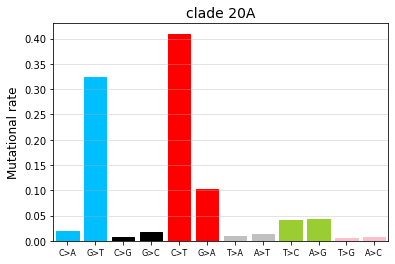

In [24]:
ax = plot_mutspec12(spectrum_20A, 'rate', 'clade 20A', 
               ylabel='Mutational rate', 
            #    savepath='./figures/20A_spectrum.png'
)

In [117]:
df_changes = collect_possible_changes(gc=1)
clade_specific_spectrum = spectrum_20A.set_index('Mut').rate.to_dict()

df_changes['rate'] = df_changes['sbs'].map(clade_specific_spectrum)

## Calculate expected AA substitutions matrix
exp_aa_subst = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
    .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
exp_aa_subst.to_csv('data/exp_aa_subst.csv', float_format='%g', index=False)
exp_aa_subst_matrix = exp_aa_subst.pivot(index='aa1', columns='aa2', values='rate').fillna(0.)


## Calculate codon and AA equilibrium frequencies
M = cdn_spectrum_to_matrix(df_changes)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs_cdn.name = 'freq'
eq_freqs_cdn.index.name = 'cdn'
eq_freqs_cdn = eq_freqs_cdn.reset_index()
eq_freqs_cdn['aa'] = eq_freqs_cdn['cdn'].map(coda.translate_codon).map(amino_acid_codes)

eq_freqs_cdn.to_csv('./data/cdn_eq_freqs.csv', index=False, float_format='%g')
eq_freqs_cdn

,cdn,freq,aa
0,AAA,0.002955,Lys
1,AAC,0.003778,Asn
2,AAG,0.001461,Lys
3,AAT,0.012720,Asn
4,ACA,0.003778,Thr
...,...,...,...
59,TGT,0.029123,Cys
60,TTA,0.054586,Leu
61,TTC,0.075297,Phe
62,TTG,0.029123,Leu


In [9]:
exp_aa_subst_matrix

aa2,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
aa1,,,,,,,,,,,,,,,,,,,,
Ala,1.000000,0.000000,0.000000,0.039035,0.000000,0.000000,0.039035,0.029938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066529,1.296591,0.406458,0.000000,0.000000,1.638057
Arg,0.000000,1.200282,0.000000,0.000000,0.819028,0.203229,0.000000,0.118037,0.203229,0.324148,1.296591,0.203229,0.324148,0.000000,0.066529,0.401635,0.033264,0.423543,0.000000,0.000000
Asn,0.000000,0.000000,0.449834,0.088100,0.000000,0.000000,0.000000,0.000000,0.015582,0.028058,0.000000,0.041901,0.000000,0.000000,0.000000,0.088100,0.015582,0.000000,0.028058,0.000000
Asp,0.015582,0.000000,0.203229,0.449834,0.000000,0.000000,0.041901,0.088100,0.033264,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.648296,0.028058
Cys,0.000000,0.080641,0.000000,0.000000,0.449834,0.000000,0.000000,0.012261,0.000000,0.000000,0.000000,0.000000,0.000000,0.648296,0.000000,0.050802,0.000000,0.013615,0.203229,0.000000
Gln,0.000000,0.088100,0.000000,0.000000,0.000000,0.145664,0.014969,0.000000,0.362600,0.000000,0.028058,0.039035,0.000000,0.000000,0.015582,0.000000,0.000000,0.000000,0.000000,0.000000
Glu,0.015582,0.000000,0.000000,0.362600,0.000000,0.033264,0.145664,0.088100,0.000000,0.000000,0.000000,0.203229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028058
Gly,0.066529,0.269758,0.000000,0.203229,0.648296,0.000000,0.203229,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.203229,0.000000,0.324148,0.000000,1.296591
His,0.000000,0.088100,0.039035,0.014969,0.000000,0.041901,0.000000,0.000000,0.449834,0.000000,0.028058,0.000000,0.000000,0.000000,0.015582,0.000000,0.000000,0.000000,0.819028,0.000000


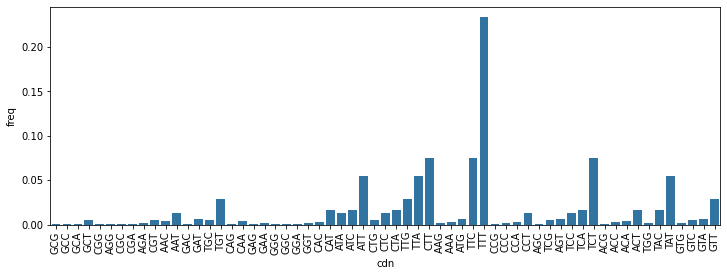

In [28]:
plt.figure(figsize=(12, 4))
sns.barplot(data=eq_freqs_cdn.sort_values(['aa', 'freq']).iloc[3:], 
            y='freq', x='cdn', )
plt.xticks(rotation=90);

In [10]:
eq_freqs_aa = eq_freqs_cdn[eq_freqs_cdn.aa !='*'].groupby('aa')['freq'].sum()
eq_freqs_aa /= eq_freqs_aa.sum()
eq_freqs_aa = eq_freqs_aa.sort_values(ascending=False).reset_index()
eq_freqs_aa.to_csv('./data/aa_eq_freqs.csv', index=False)
eq_freqs_aa.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
aa,Phe,Leu,Ser,Ile,Tyr,Val,Cys,Thr,His,Pro,Asn,Arg,Asp,Ala,Met,Gln,Lys,Gly,Glu,Trp
freq,0.316848,0.19828,0.12015,0.086402,0.073345,0.043425,0.034829,0.025139,0.020164,0.018112,0.016935,0.008895,0.007793,0.006973,0.006696,0.004975,0.004532,0.002684,0.001922,0.001901


## Load OBS

In [11]:
# https://media.githubusercontent.com/media/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/mutation_counts/aggregated.csv
obs_raw = pd.read_csv('data/aggregated.csv').query('subset == "all" & exclude == False')
obs = obs_raw[(obs_raw['synonymous'] == False)]

def _same_aa_mut(aa_mutation: str):
    variants = aa_mutation.split(';')
    return variants.count(variants[0]) == len(variants)

obs = obs[obs.aa_mutation.apply(_same_aa_mut)]
obs['aa1'] = obs['aa_mutation'].str[0]
obs['aa2'] = obs['aa_mutation'].str[-1]
# # obs['Mut'] = obs['mut_type'].str.replace('to', '>')
# same as in the paper table
# obs[obs.four_fold_degenerate].groupby('clade')['count'].sum().sort_index()
obs

,protein,aa_mutation,nt_mutation,codon_change,synonymous,count,nt_site,reference_nt,clade_founder_nt,exclude,exclude_reason,clade,subset,codon_position,four_fold_degenerate,aa1,aa2
0,ORF1ab,P5401L,C16466T,CCA>CTA,False,62,16466,C,C,False,NaN,19A,all,2,False,P,L
1,M,I82T,T26767C,ATC>ACC,False,54,26767,T,T,False,NaN,19A,all,2,False,I,T
3,ORF1ab,A6319V,C19220T,GCT>GTT,False,46,19220,C,C,False,NaN,19A,all,2,False,A,V
4,ORF1ab,I5658V,A17236G,ATA>GTA,False,45,17236,A,A,False,NaN,19A,all,1,False,I,V
5,ORF1ab,P4715L,C14408T,CCT>CTT,False,45,14408,C,C,False,NaN,19A,all,2,False,P,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979828,ORF1a;ORF1ab,T2756A;T2756A,A8531G,ACA>GCA;ACA>GCA,False,1,8531,A,A,False,NaN,22C,all,1,False,T,A
979829,ORF1a;ORF1ab,T2777A;T2777A,A8594G,ACA>GCA;ACA>GCA,False,1,8594,A,A,False,NaN,22C,all,1,False,T,A
979832,ORF1a;ORF1ab,T2825N;T2825N,C8739A,ACT>AAT;ACT>AAT,False,1,8739,C,C,False,NaN,22C,all,2,False,T,N
979833,ORF1a;ORF1ab,T2836A;T2836A,A8771G,ACA>GCA;ACA>GCA,False,1,8771,A,A,False,NaN,22C,all,1,False,T,A


### Explore OBS

In [15]:
obs_raw['count'].sum(), obs['count'].sum()

(np.int64(4132247), np.int64(2412204))

In [16]:
print('Number of mutations:')
obs_raw.groupby(['clade', 'synonymous'])['count'].sum().unstack()

Number of mutations:


synonymous,False,True
clade,,
19A,6576,3719
20A,58961,39770
20B,47332,32000
20C,31891,21898
20E,35238,24037
20F,2202,1311
20G,45508,33280
20I,207215,143847
20J,13188,9550


In [17]:
print('Number of mutations:')
obs_raw.query('synonymous == True').groupby(['clade', 'four_fold_degenerate'])['count'].sum().unstack()

Number of mutations:


four_fold_degenerate,False,True
clade,,
19A,2118,1601
20A,22568,17202
20B,17879,14121
20C,12554,9344
20E,13583,10454
20F,761,550
20G,19261,14019
20I,82989,60858
20J,5314,4236


In [18]:
obs.groupby('clade')['count'].sum().rename('aa_subst_cnt').sort_index().reset_index()

,clade,aa_subst_cnt
0,19A,6576
1,20A,58957
2,20B,47324
3,20C,31885
4,20E,35227
5,20F,2199
6,20G,45501
7,20I,207190
8,20J,13186
9,21C,20980


### Check site specifity

In [12]:
ref_sites_df = read_genbank_ref('data/NC_045512.2.gb')
ref_sites_df = ref_sites_df[ref_sites_df.Codon.notna()]
# Pos and nt_site is the same
ref_sites_df

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/Bio/SeqFeature.py:230: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(
/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/Bio/SeqFeature.py:230: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(


,Pos,Nuc,Context,Strand,Type,gene,PosInGene,PosInCodon,Codon
265,266,A,GAT,1,mat_peptide,ORF1ab,1,1,ATG
266,267,T,ATG,1,mat_peptide,ORF1ab,2,2,ATG
267,268,G,TGG,1,mat_peptide,ORF1ab,3,3,ATG
268,269,G,GGA,1,mat_peptide,ORF1ab,4,1,GAG
269,270,A,GAG,1,mat_peptide,ORF1ab,5,2,GAG
...,...,...,...,...,...,...,...,...,...
29669,29670,C,ACA,1,CDS,ORF10,113,2,ACA
29670,29671,A,CAT,1,CDS,ORF10,114,3,ACA
29671,29672,T,ATA,1,CDS,ORF10,115,1,TAG
29672,29673,A,TAG,1,CDS,ORF10,116,2,TAG


In [13]:
ref_sites_df['MutCount'] = ref_sites_df['Pos'].map(obs.groupby('nt_site')['count'].sum()).fillna(0.)
ref_sites_df = ref_sites_df.merge(obs[['nt_site', 'codon_position']].drop_duplicates(), 
                   left_on='Pos', right_on='nt_site', how='left')
ref_sites_df

,Pos,Nuc,Context,Strand,Type,gene,PosInGene,PosInCodon,Codon,MutCount,nt_site,codon_position
0,266,A,GAT,1,mat_peptide,ORF1ab,1,1,ATG,0.0,NaN,NaN
1,267,T,ATG,1,mat_peptide,ORF1ab,2,2,ATG,1.0,267.0,2
2,268,G,TGG,1,mat_peptide,ORF1ab,3,3,ATG,0.0,NaN,NaN
3,269,G,GGA,1,mat_peptide,ORF1ab,4,1,GAG,149.0,269.0,1
4,270,A,GAG,1,mat_peptide,ORF1ab,5,2,GAG,111.0,270.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
29255,29670,C,ACA,1,CDS,ORF10,113,2,ACA,515.0,29670.0,2
29256,29671,A,CAT,1,CDS,ORF10,114,3,ACA,1.0,29671.0,3
29257,29672,T,ATA,1,CDS,ORF10,115,1,TAG,0.0,NaN,NaN
29258,29673,A,TAG,1,CDS,ORF10,116,2,TAG,0.0,NaN,NaN


In [33]:
ref_sites_df.MutCount.describe()

count    29260.000000
mean        82.440328
std        211.040767
min          0.000000
25%          1.000000
50%         16.000000
75%         68.000000
max       6323.000000
Name: MutCount, dtype: float64

In [34]:
ref_sites_df.MutCount.value_counts(normalize=True).rename('freq').reset_index()

,MutCount,freq
0,0.0,0.226384
1,1.0,0.051504
2,2.0,0.035954
3,3.0,0.026487
4,4.0,0.023377
...,...,...
1171,1261.0,0.000034
1172,1249.0,0.000034
1173,1117.0,0.000034
1174,1655.0,0.000034


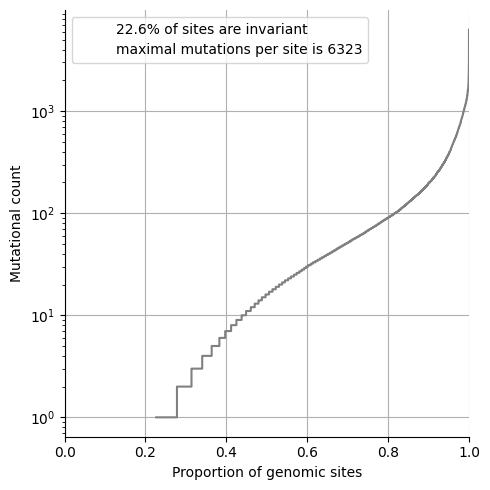

In [23]:
import matplotlib.patches as mpatches

sns.displot(ref_sites_df, y='MutCount', kind='ecdf', log_scale=(False, True), color='gray')
plt.legend([
        mpatches.Patch(color='none'), 
        mpatches.Patch(color='none'),
    ],[
        '22.6% of sites are invariant', 'maximal mutations per site is 6323'], 
    loc='upper left')
plt.grid(True)
plt.ylabel('Mutational count')
plt.xlabel('Proportion of genomic sites')
plt.tight_layout()
# plt.savefig('./figures/mutational_count_per_site_ecdf.pdf', dpi=300)
plt.show()

### compare obs and exp in table

In [35]:
grantham = pd.read_csv('../grantham.tsv', sep='\t', index_col=0).replace(0, np.nan)
grantham.index.name = 'aa1'
grantham_long = grantham.melt(ignore_index=False, var_name='aa2', value_name='granthamD').dropna().reset_index()
grantham_long['aa1'] = grantham_long['aa1'].map(amino_acid_codes)
grantham_long['aa2'] = grantham_long['aa2'].map(amino_acid_codes)
grantham_long = pd.concat([grantham_long, grantham_long.rename(columns={'aa1':'aa2', 'aa2':'aa1'})], ignore_index=True)
grantham_long

,aa1,aa2,granthamD
0,Ser,Arg,110.0
1,Ser,Leu,145.0
2,Arg,Leu,102.0
3,Ser,Pro,74.0
4,Arg,Pro,103.0
...,...,...,...
375,Trp,Asn,174.0
376,Trp,Lys,110.0
377,Trp,Asp,181.0
378,Trp,Glu,152.0


In [118]:
obs_clade = obs[obs['clade'] == '20A']
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
aa_subst['label'] = aa_subst.aa1 + '>' + aa_subst.aa2
aa_subst['mape'] = aa_subst['mape'].replace(-np.inf, 0)
aa_subst['diff_freqs_abs'] = (aa_subst['nobs_freqs'] - aa_subst['nexp_freqs']).abs()
aa_subst['division'] = (aa_subst['nobs_freqs'] / aa_subst['nexp_freqs'])
aa_subst['dist_to_diagonal'] = aa_subst['diff_freqs_abs'] / (2**0.5)
aa_subst = aa_subst.merge(grantham_long, 'left')
aa_subst.sort_values('mape')

NameError: name 'grantham_long' is not defined

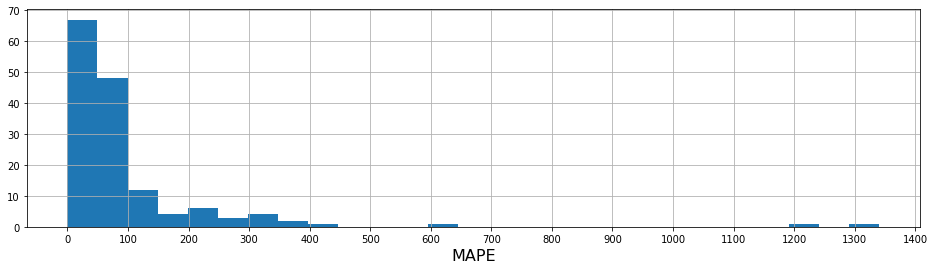

In [37]:
plt.figure(figsize=(16, 4))
(aa_subst.mape.abs()*100).hist(bins=27)
plt.xlabel('MAPE', fontsize=16)
plt.xticks(range(0, 1500, 100));

In [38]:
aa_subst.query('label == "Ser>Trp"')

,aa1,aa2,nobs,ref_aa1_freq,nobs_scaled,rate_exp,nexp,diff,mape,nobs_freqs,nexp_freqs,label,diff_freqs_abs,division,dist_to_diagonal,granthamD
121,Ser,Trp,0.0,0.0,0.0,0.007484,14.203554,-14.203554,0.0,0.0,0.000243,Ser>Trp,0.000243,0.0,0.000172,177.0


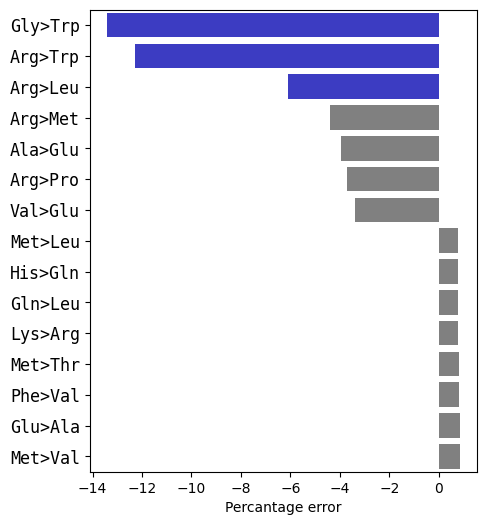

In [24]:
a = aa_subst['mape'][aa_subst['mape']>0].quantile(0.9)
b = aa_subst['mape'][aa_subst['mape']<0].quantile(0.1)

_d = aa_subst[(aa_subst['mape'] > a) | (aa_subst['mape'] < b)].copy()

plt.figure(figsize=(5, 6))
sns.barplot(aa_subst, y='label', x='mape', color='gray',
            order=_d.sort_values('mape').label)

# sns.barplot(aa_subst, y='label', x='mape', color='red', alpha=0.7,
#             order=_d.sort_values('mape').tail(3).label)
sns.barplot(aa_subst, y='label', x='mape', color='blue', alpha=0.7,
            order=_d.sort_values('mape').head(3).label)

plt.ylabel('')
# plt.xlim(-0.45, 0.45)
plt.xlabel('Percantage error')
plt.yticks(fontsize=12, fontname='monospace')
plt.show()

<Axes: >

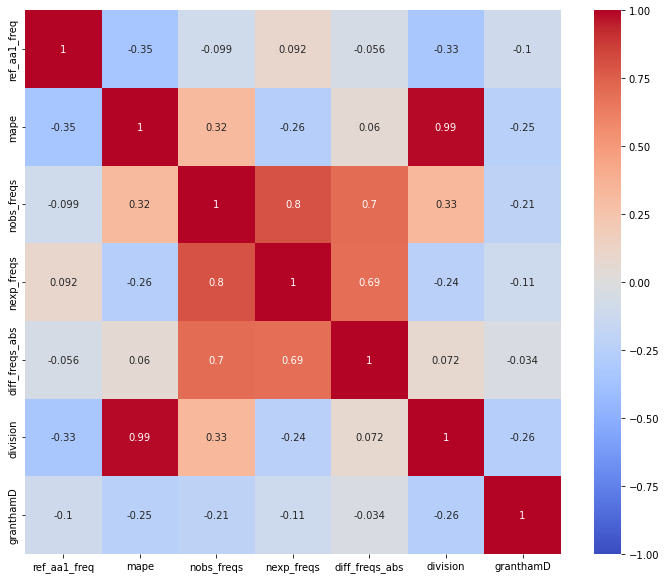

In [39]:
plt.figure(figsize=(12, 10))
sns.heatmap(aa_subst.drop(['aa1', 'aa2', 'label', 'nobs', 'nexp', 'nobs_scaled', 'dist_to_diagonal', 'diff', 'rate_exp'], axis=1).corr('spearman'), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)

Text(0, 0.5, 'Difference between OBS and PRED freqs')

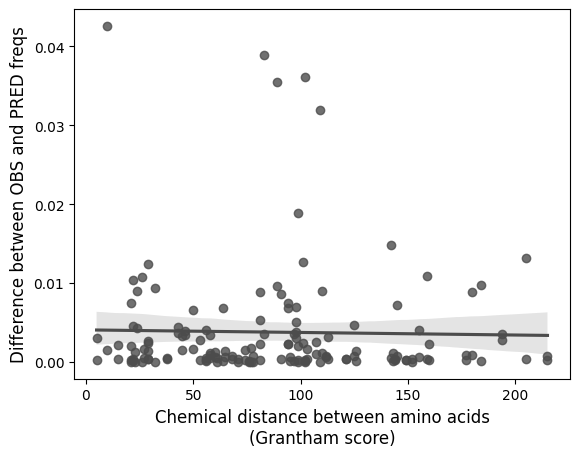

In [25]:
# plt.figure(figsize=(8, 8))
sns.regplot(aa_subst, x='granthamD', y='diff_freqs_abs', color='.3')
plt.xlabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
plt.ylabel('Difference between OBS and PRED freqs', fontsize=12)
# plt.xscale('log')
# # plt.yscale('log')
# plt.text(2.5e-2, -3, '${MAPE=const}$', {'size': 16})
# plt.ylabel('MAPE')
# plt.xlabel('Observed frequency of amino acid substitution')

Text(0.5, 0, 'Observed frequency of amino acid substitution')

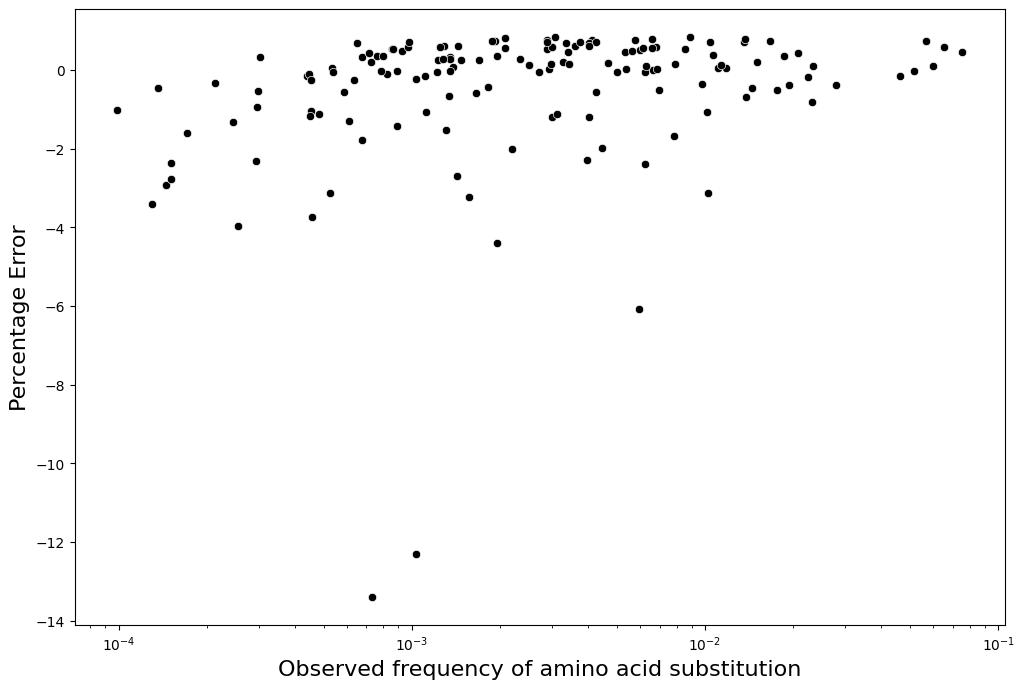

In [26]:
plt.figure(figsize=(12, 8))
sns.scatterplot(aa_subst, x='nobs_freqs', y='mape', c='k')
plt.xscale('log')
# plt.yscale('log')
# plt.text(2.5e-2, -3, '${MAPE=const}$', {'size': 16})
plt.ylabel('Percentage Error', fontsize=16)
plt.xlabel('Observed frequency of amino acid substitution', fontsize=16)

### Model definition and equilibrium

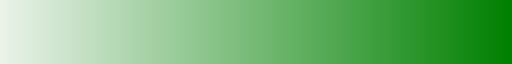

In [32]:
sns.color_palette("light:green", as_cmap=True)

In [27]:
def plot_exp_heatmap(exp_aa_subst_matrix: pd.DataFrame, save_path: str, show=True, annot=False):
    """
    Plot expected amino acid substitution matrix.
    """
    freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
    freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()
    max_flow_value = max(freqs_to.max(), freqs_from.max())+0.1

    fig, axs = plt.subplots(2, 3, figsize=(11, 10), 
                            width_ratios=[0.1, 1, .05], height_ratios=[1, 0.1])
    sns.heatmap(exp_aa_subst_matrix, annot=annot, fmt=".2f", 
                ax=axs[0, 1], cbar_ax=axs[0, 2], 
                cmap=sns.color_palette("light:green", as_cmap=True), 
                cbar_kws={'label': 'Substitution rate'}, vmin=0,
                mask=exp_aa_subst_matrix==0,
    )
    axs[0, 1].set_ylabel('')
    axs[0, 1].set_xlabel('')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    # axs[0, 1].set_title('Expected substitution rates between amino acids')

    sns.barplot(freqs_from.reset_index(), y='aa1', x=0, ax=axs[0, 0],
                color='lightgray', edgecolor='black')
    axs[0, 0].set_ylabel('Original', fontsize=14)
    axs[0, 0].set_xlabel('Total Loss')
    axs[0, 0].spines['top'].set_visible(False)
    axs[0, 0].spines['right'].set_visible(False)
    axs[0, 0].spines['bottom'].set_visible(False)
    axs[0, 0].spines['left'].set_visible(False)
    axs[0, 0].invert_xaxis()
    axs[1, 1].set_ylim(0, max_flow_value)
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)

    sns.barplot(freqs_to.reset_index(), x='aa2', y=0, ax=axs[1, 1],
                color='lightgray', edgecolor='black')
    axs[1, 1].set_ylabel('Total Gain')
    axs[1, 1].set_xlabel('Mutant', fontsize=14)
    axs[1, 1].spines['top'].set_visible(False)
    axs[1, 1].spines['right'].set_visible(False)
    axs[1, 1].spines['bottom'].set_visible(False)
    axs[1, 1].spines['left'].set_visible(False)
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_ylim(max_flow_value, 0)
    axs[1, 1].set_yticks([])
    axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)

    axs[1, 0].remove()
    axs[1, 2].remove()

    plt.tight_layout()
    plt.savefig(save_path)
    if show:
        plt.show()
    else:
        plt.close(fig)

/tmp/ipykernel_561395/665892802.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)
/tmp/ipykernel_561395/665892802.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)


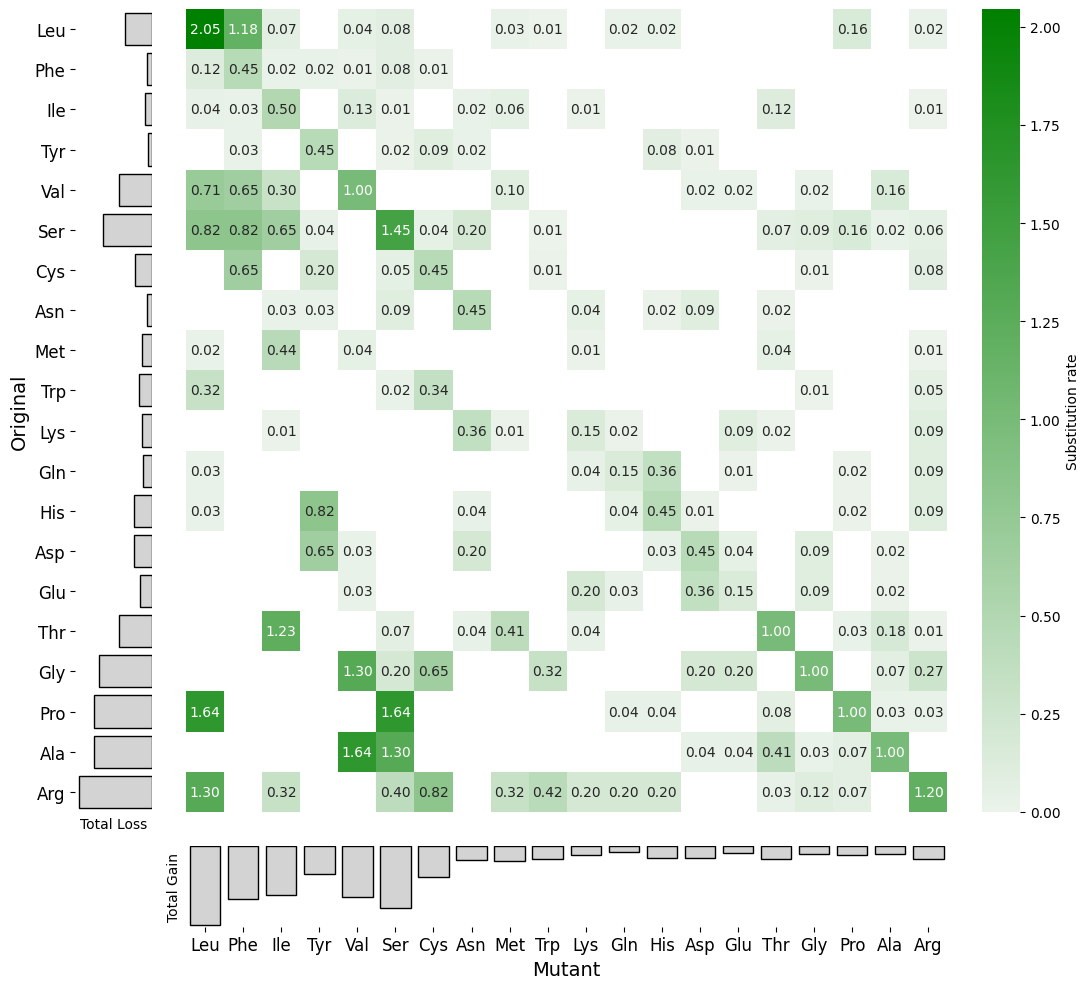

In [28]:
_, exp_aa_subst_matrix = prepare_exp_aa_subst(spectrum_20A, gc=1)

freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

_freqs_to = (freqs_to / freqs_to.sum()).copy()
_freqs_from = (freqs_from / freqs_from.sum()).copy()
_freqs_to.index.name = 'aa'
_freqs_from.index.name = 'aa'

flow = (_freqs_to - _freqs_from).sort_values(ascending=False).rename('Flow').reset_index()

plot_exp_heatmap(exp_aa_subst_matrix.loc[flow.aa, flow.aa], 
                 'figures/exp_exp_aa_subst_matrix_20A.pdf', show=True, annot=True)

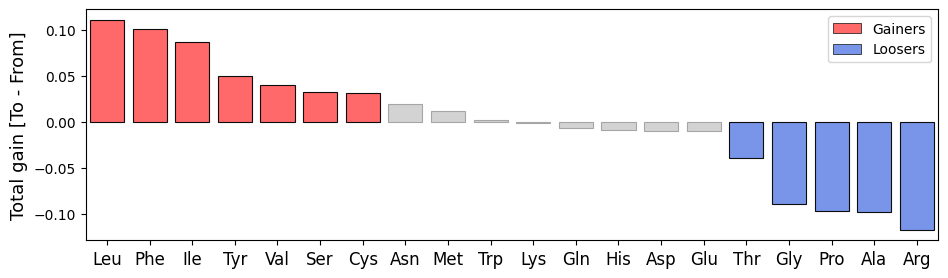

In [29]:
plt.figure(figsize=(11, 3))
ax = sns.barplot(
    flow, x='aa', y='Flow', color='lightgray', edgecolor=".65", linewidth=0.8)

cutoff = flow.Flow.abs().max() * 0.25

for bar in ax.patches:
    if bar.get_height() > cutoff:
        bar.set_color("#ff6969")
        bar.set_edgecolor('0.05')
    elif bar.get_height() < -cutoff:
        bar.set_color('#7995ea')
        bar.set_edgecolor('0.05')
        bar.set_linewidth


plt.legend([
    plt.Rectangle((0,0),1,1,fc="#ff6969", edgecolor='.05',linewidth=0.5), 
    plt.Rectangle((0,0),1,1,fc='#7995ea', edgecolor='.05',linewidth=0.5),
    ],['Gainers', 'Loosers',], loc='upper right')

# plt.title(f"{virusname}; G: {losers_gainers[i]['gainers']}; L: {losers_gainers[i]['losers']}")
plt.ylabel('Total gain [To - From]', fontsize=13)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.show()

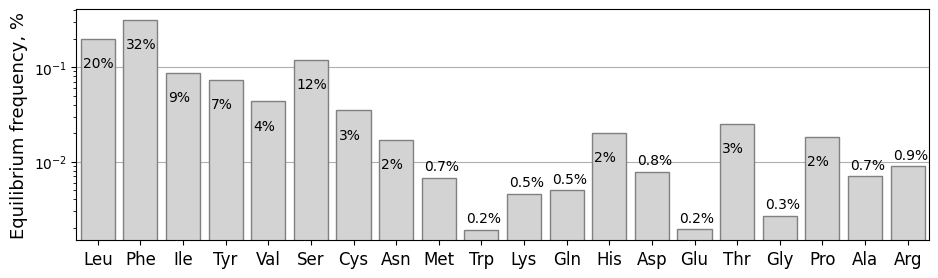

In [ ]:
cur_eq_freqs_aa = pd.read_csv('./data/aa_eq_freqs.csv')

plt.figure(figsize=(11, 3))
ax=sns.barplot(cur_eq_freqs_aa, x='aa', y='freq', order=flow.aa, color='lightgray', edgecolor='gray')

for i, aa in enumerate(flow.aa.values):
    f = cur_eq_freqs_aa.query('aa == @aa').freq.item()
    x = i-0.35
    if f < 0.016:
        lbl = f"{f*100:.1f}%" 
        y = f * 1.2
    else:
        lbl = f"{f*100:.0f}%"
        y = f * 0.5
    ax.text(x, y, lbl)

plt.ylabel('Equilibrium frequency, %', fontsize=13)
plt.xticks(fontsize=12)
# plt.ylim(0, 1)
plt.xlabel('')
plt.yscale('log', base=10)
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

In [31]:
flow.head(7).aa

0    Leu
1    Phe
2    Ile
3    Tyr
4    Val
5    Ser
6    Cys
Name: aa, dtype: object

In [32]:
cur_eq_freqs_aa[cur_eq_freqs_aa.aa.isin(flow.head(7).aa)].freq.sum().round(2)

np.float64(0.87)

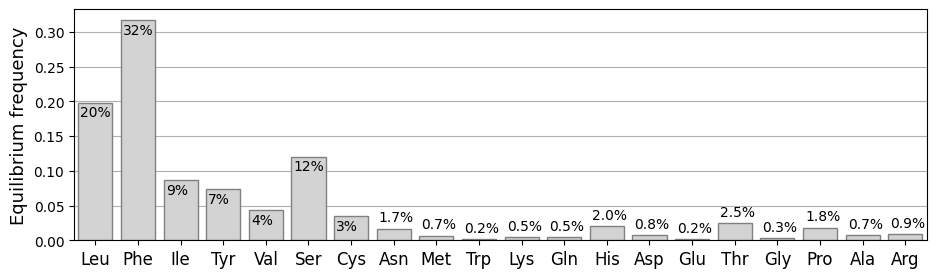

In [ ]:
plt.figure(figsize=(11, 3))
ax=sns.barplot(cur_eq_freqs_aa, x='aa', y='freq', order=flow.aa, color='lightgray', edgecolor='gray')

for i, aa in enumerate(flow.aa.values):
    f = cur_eq_freqs_aa.query('aa == @aa').freq.item()
    x = i-0.35
    if f < 0.03:
        lbl = f"{f*100:.1f}%" 
        y = f + 0.01
    else:
        lbl = f"{f*100:.0f}%"
        y = f - 0.02
    ax.text(x, y, lbl)

plt.ylabel('Equilibrium frequency', fontsize=13)
plt.xticks(fontsize=12)
plt.xlabel('')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

In [40]:
aa_subst

,aa1,aa2,nobs,ref_aa1_freq,nobs_scaled,rate_exp,nexp,diff,mape,nobs_freqs,nexp_freqs,label,diff_freqs_abs,division,dist_to_diagonal,granthamD
0,Ala,Asp,108.0,0.067529,80.767501,0.039035,74.078845,6.688656,0.082814,0.001383,0.001269,Ala>Asp,0.000115,1.090291,0.000081,126.0
1,Ala,Glu,20.0,0.067529,14.956945,0.039035,74.078845,-59.121901,-3.952806,0.000256,0.001269,Ala>Glu,0.001013,0.201906,0.000716,107.0
2,Ala,Gly,23.0,0.067529,17.200486,0.029938,56.814214,-39.613728,-2.303059,0.000295,0.000973,Ala>Gly,0.000678,0.302750,0.000480,60.0
3,Ala,Pro,41.0,0.067529,30.661737,0.066529,126.254954,-95.593218,-3.117671,0.000525,0.002162,Ala>Pro,0.001637,0.242856,0.001158,27.0
4,Ala,Ser,1814.0,0.067529,1356.594886,1.296591,2460.606550,-1104.011664,-0.813811,0.023233,0.042141,Ala>Ser,0.018908,0.551325,0.013370,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Val,Gly,73.0,0.080152,45.994999,0.024521,46.535588,-0.540589,-0.011753,0.000788,0.000797,Val>Gly,0.000009,0.988383,0.000007,109.0
146,Val,Ile,1055.0,0.080152,664.722244,0.304843,578.516581,86.205663,0.129687,0.011384,0.009908,Val>Ile,0.001476,1.149012,0.001044,29.0
147,Val,Leu,1281.0,0.080152,807.117720,0.714824,1356.558229,-549.440509,-0.680744,0.013823,0.023233,Val>Leu,0.009410,0.594975,0.006654,32.0
148,Val,Met,121.0,0.080152,76.238286,0.101614,192.838860,-116.600574,-1.529423,0.001306,0.003303,Val>Met,0.001997,0.395347,0.001412,21.0


### subst freqs plot

In [120]:
def plot_subst_freqs(aa_subst, title=''):
    aa_subst = aa_subst.copy()
    aa_subst['nobs_freqs_log'] = np.log10(aa_subst['nobs_freqs'])
    aa_subst['nexp_freqs_log'] = np.log10(aa_subst['nexp_freqs'])

    y_true, y_pred = aa_subst['nobs_freqs'], aa_subst['nexp_freqs']
    cor_res = spearmanr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Spearman correlation: {cor_res.correlation:.3f} (p-value: {cor_res.pvalue:.3g})")

    plt.figure(figsize=(8, 8))
    ax = sns.regplot(aa_subst[aa_subst['nobs_freqs']>0], 
                color='blue', scatter_kws={'alpha':0.5, 's':50},
                y='nobs_freqs_log', x='nexp_freqs_log')

    ticks = np.linspace(-4, -1, 4)
    ticks_minor = np.log10(np.concat([
        np.linspace(10**-4, 10**-3, 10),
        np.linspace(10**-3, 10**-2, 10)[1:],
        np.linspace(10**-2, 10**-1, 10)[1:],
    ]))
    ax.set_xticks(ticks, ticks, size=14)
    ax.set_yticks(ticks, ticks, size=14)
    ax.set_xticks(ticks_minor, minor=True)
    ax.set_yticks(ticks_minor, minor=True)
    formatter = lambda x, pos: '10$^{' + str(int(x)) + '}$'
    ax.get_xaxis().set_major_formatter(formatter)
    ax.get_yaxis().set_major_formatter(formatter)
    # ax.get_xaxis().set_minor_locator(LogLocator(-10, 'auto'))
    # ax.get_xaxis().set_minor_locator(LogLocator())

    # plt.text(-2, -4., 
    #          f"r={cor_res.correlation:.1f} (p={cor_res.pvalue:.1g})", 
    #          fontsize=10)
    plt.plot([-4, -1], [-4, -1], color='black', linestyle='--',)
    plt.ylabel('Observed AA substitution frequencies', fontsize=14)
    plt.xlabel('Predicted AA substitution frequencies', fontsize=14)
    plt.title(title, fontsize=16)
    # plt.legend(title=f"spearmanr={cor_res.correlation:.2f} (p={cor_res.pvalue:.1g})", title_fontsize=14)
    plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=14)
    # plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
    plt.show()

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Spearman correlation: 0.805 (p-value: 2.61e-35)


/tmp/ipykernel_112608/821270983.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=14)


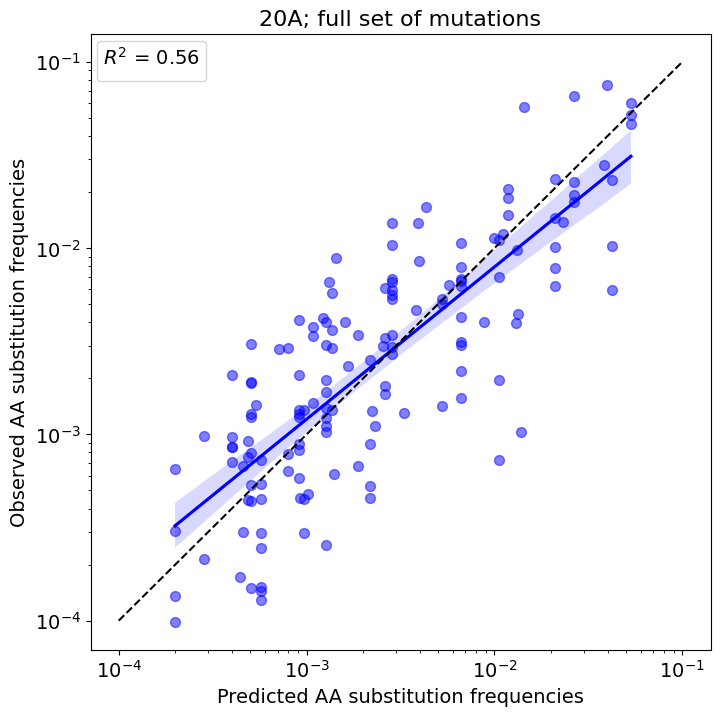

In [119]:
obs_clade = obs[obs['clade'] == '20A']
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(aa_subst, '20A; full set of mutations', )

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


pos=1: $R^2$ = 0.63
pos=2: $R^2$ = 0.62
pos=3: $R^2$ = 0.42


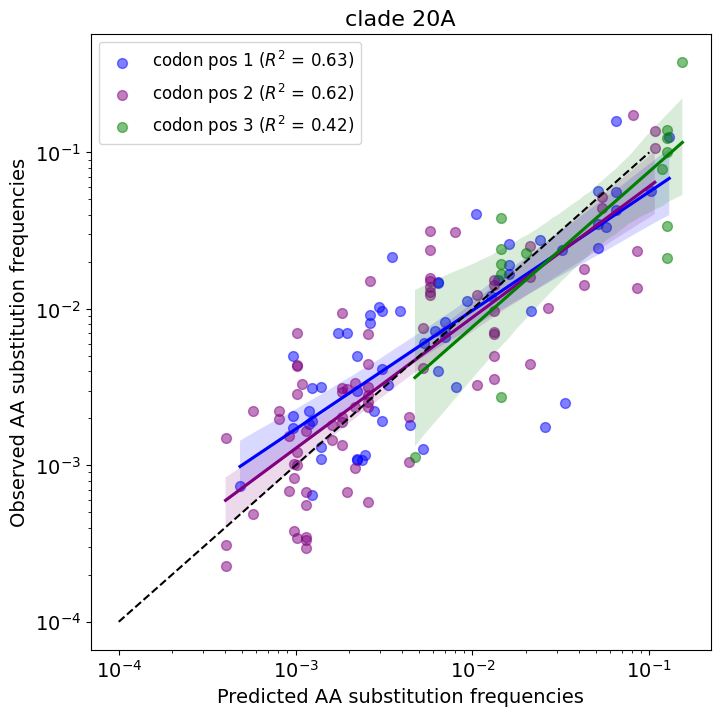

In [44]:
title = 'clade 20A'

_exp_aa_subst1 = df_changes[
    (df_changes.aa1 != '*') & 
    (df_changes.aa2 != '*') &
    (df_changes.pic == 0)
].groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
_exp_aa_subst2 = df_changes[
    (df_changes.aa1 != '*') & 
    (df_changes.aa2 != '*') &
    (df_changes.pic == 1)
].groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
_exp_aa_subst3 = df_changes[
    (df_changes.aa1 != '*') & 
    (df_changes.aa2 != '*') &
    (df_changes.pic == 2)
].groupby(['aa1', 'aa2'])['rate'].sum().reset_index()


_aa_subst1 = prepare_aa_subst(obs_clade.query(f'codon_position == "1"'), _exp_aa_subst1, aa_freqs_total_dct)
_aa_subst2 = prepare_aa_subst(obs_clade.query(f'codon_position == "2"'), _exp_aa_subst2, aa_freqs_total_dct)
_aa_subst3 = prepare_aa_subst(obs_clade.query(f'codon_position == "3"'), _exp_aa_subst3, aa_freqs_total_dct)


_aa_subst1['nobs_freqs_log'] = np.log10(_aa_subst1['nobs_freqs'])
_aa_subst1['nexp_freqs_log'] = np.log10(_aa_subst1['nexp_freqs'])
_aa_subst2['nobs_freqs_log'] = np.log10(_aa_subst2['nobs_freqs'])
_aa_subst2['nexp_freqs_log'] = np.log10(_aa_subst2['nexp_freqs'])
_aa_subst3['nobs_freqs_log'] = np.log10(_aa_subst3['nobs_freqs'])
_aa_subst3['nexp_freqs_log'] = np.log10(_aa_subst3['nexp_freqs'])

r2_1 = r2_score(_aa_subst1['nobs_freqs'], _aa_subst1['nexp_freqs'])
r2_2 = r2_score(_aa_subst2['nobs_freqs'], _aa_subst2['nexp_freqs'])
r2_3 = r2_score(_aa_subst3['nobs_freqs'], _aa_subst3['nexp_freqs'])
print(f"pos=1: $R^2$ = {r2_1:.2f}")
print(f"pos=2: $R^2$ = {r2_2:.2f}")
print(f"pos=3: $R^2$ = {r2_3:.2f}")

plt.figure(figsize=(8, 8))
sns.regplot(_aa_subst1[_aa_subst1['nobs_freqs']>0], 
            color='blue', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 1 ($R^2$ = {r2_1:.2f})')

sns.regplot(_aa_subst2[_aa_subst2['nobs_freqs']>0], 
            color='purple', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 2 ($R^2$ = {r2_2:.2f})')


ax = sns.regplot(_aa_subst3[_aa_subst3['nobs_freqs']>0], 
            color='green', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 3 ($R^2$ = {r2_3:.2f})')

ticks = np.linspace(-4, -1, 4)
ticks_minor = np.log10(np.concat([
    np.linspace(10**-4, 10**-3, 10),
    np.linspace(10**-3, 10**-2, 10)[1:],
    np.linspace(10**-2, 10**-1, 10)[1:],
]))
ax.set_xticks(ticks, ticks, size=14)
ax.set_yticks(ticks, ticks, size=14)
ax.set_xticks(ticks_minor, minor=True)
ax.set_yticks(ticks_minor, minor=True)
formatter = lambda x, pos: '10$^{' + str(int(x)) + '}$'
ax.get_xaxis().set_major_formatter(formatter)
ax.get_yaxis().set_major_formatter(formatter)
# ax.get_xaxis().set_minor_locator(LogLocator(-10, 'auto'))
# ax.get_xaxis().set_minor_locator(LogLocator())

# plt.text(-2, -4., 
#          f"r={r2_.correlation:.1f} (p={r2_.pvalue:.1g})", 
#          fontsize=10)
plt.plot([-4, -1], [-4, -1], color='black', linestyle='--',)
plt.ylabel('Observed AA substitution frequencies', fontsize=14)
plt.xlabel('Predicted AA substitution frequencies', fontsize=14)
plt.title(title, fontsize=16)
plt.legend(fontsize=12)
# plt.legend(title=f"spearmanr={r2_.correlation:.2f} (p={r2_.pvalue:.1g})", title_fontsize=14)
plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
plt.show()

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Spearman correlation: 0.686 (p-value: 3.73e-22)


/tmp/ipykernel_112608/821270983.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=14)


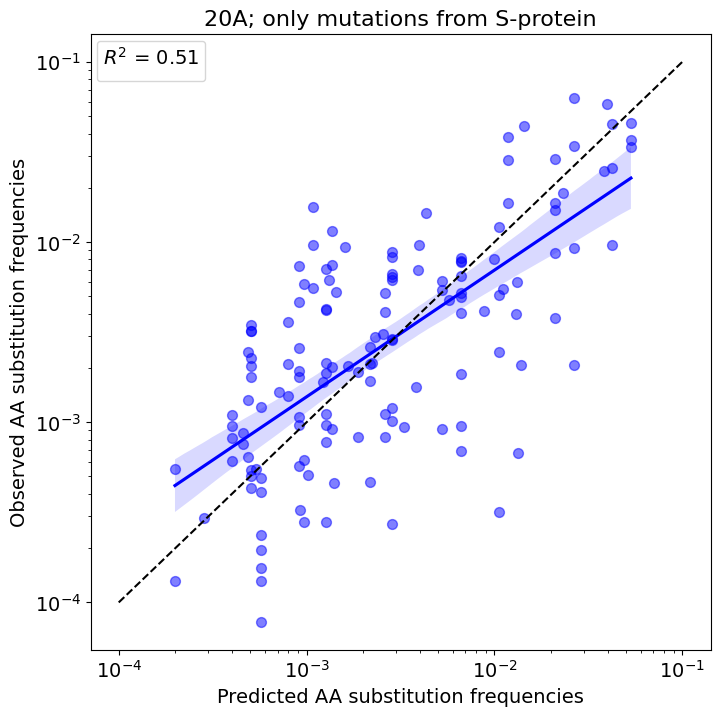

In [45]:
_aa_subst = prepare_aa_subst(obs_clade[obs_clade.protein == 'S'], exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(_aa_subst, '20A; only mutations from S-protein', )

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_112608/821270983.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=14)


Spearman correlation: 0.771 (p-value: 8.11e-31)


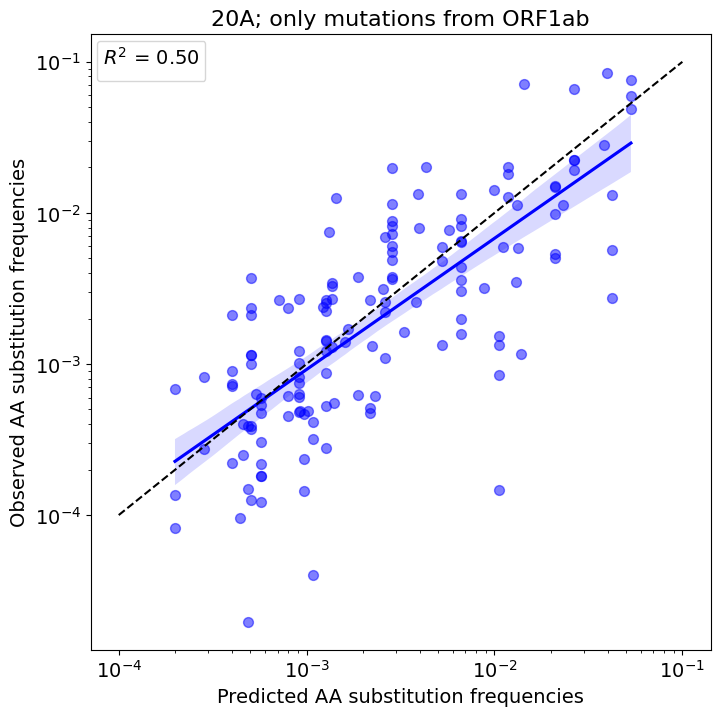

In [46]:
# _aa_subst = prepare_aa_subst(obs_clade[obs_clade.protein == 'ORF1ab'], exp_aa_subst, aa_freqs_total_dct)
_aa_subst = prepare_aa_subst(obs_clade[obs_clade.protein.str.contains('ORF1ab')], exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(_aa_subst, '20A; only mutations from ORF1ab', )

### separate on genes

In [47]:
metrics_data = []
for (cur_clade, cur_protein), cur_obs in obs.groupby(['clade', 'protein']):
    if cur_clade not in clades_spectra['clade'].values:
        continue
    spectrum_clade = clades_spectra[clades_spectra['clade'] == cur_clade]
    exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    
    cur_obs = cur_obs[(cur_obs.aa1 != '*') & (cur_obs.aa2 != '*')]
    aa_subst = prepare_aa_subst(cur_obs, exp_aa_subst, aa_freqs_total_dct)

    aa_subst = aa_subst.dropna()
    y_true = aa_subst.nobs_scaled
    y_pred = aa_subst.nexp
    
    mask = y_true > 0
    wape = weighted_average_percentage_error(y_true[mask], y_pred[mask])
    spearman_corr, spearman_p = spearmanr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics_data.append({
        'clade': cur_clade,
        'protein': cur_protein,
        'wape': wape,
        'r2': r2,
        'spearmanr': spearman_corr,
        'spearmanp': spearman_p,
    })

metrics_data = pd.DataFrame(metrics_data)
metrics_data

,clade,protein,wape,r2,spearmanr,spearmanp
0,20A,E,0.820378,0.347779,0.521083,8.134152e-12
1,20A,M,0.812821,0.160542,0.671965,4.810653e-21
2,20A,N,0.650040,0.544895,0.665981,1.418051e-20
3,20A,ORF10,0.591210,0.350739,0.402245,3.352482e-07
4,20A,ORF1a;ORF1ab,0.703054,0.481470,0.745819,6.755273e-28
...,...,...,...,...,...,...
163,22C,ORF6,0.748955,0.099033,0.248582,2.159835e-03
164,22C,ORF7a,0.700381,0.478526,0.544606,5.841855e-13
165,22C,ORF7b,0.805750,0.081877,0.259994,1.313259e-03
166,22C,ORF8,0.744769,0.267746,0.533406,2.099540e-12


In [48]:
metrics_data[metrics_data.spearmanp > 0.05]

,clade,protein,wape,r2,spearmanr,spearmanp
105,21J,ORF7b,0.869784,0.030911,0.075456,0.358766
117,21K,ORF7b,0.800905,0.089296,0.108036,0.188188
129,21L,ORF7b,0.763296,0.061544,0.110165,0.179582
141,22A,ORF7b,0.757496,0.014914,0.152445,0.062554


In [71]:
obs_clade.groupby('protein')['count'].sum().sort_values()

protein
E                 401
ORF7b             409
ORF6              435
ORF10             476
M                 950
ORF8             1206
ORF7a            1608
ORF3a            3258
N                4393
S                6862
ORF1ab           9950
ORF1a;ORF1ab    25900
Name: count, dtype: int64

In [ ]:
metrics_data_sized = metrics_data.merge(
    obs_clade.groupby('protein')['count'].sum().rename('nmut').reset_index())
metrics_data_sized

,clade,protein,wape,r2,spearmanr,spearmanp,nmut
0,20A,E,0.820378,0.347779,0.521083,8.134152e-12,488
1,20A,M,0.812821,0.160542,0.671965,4.810653e-21,967
2,20A,N,0.650040,0.544895,0.665981,1.418051e-20,4866
3,20A,ORF10,0.591210,0.350739,0.402245,3.352482e-07,432
4,20A,ORF1a;ORF1ab,0.703054,0.481470,0.745819,6.755273e-28,23635
...,...,...,...,...,...,...,...
163,22C,ORF6,0.748955,0.099033,0.248582,2.159835e-03,453
164,22C,ORF7a,0.700381,0.478526,0.544606,5.841855e-13,1472
165,22C,ORF7b,0.805750,0.081877,0.259994,1.313259e-03,501
166,22C,ORF8,0.744769,0.267746,0.533406,2.099540e-12,1906


In [60]:
metrics_data_sized.set_index(['clade', 'protein']).corr('spearman')

,wape,r2,spearmanr,spearmanp,nmut
wape,1.000000,-0.851205,-0.572980,0.572980,-0.584278
r2,-0.851205,1.000000,0.675153,-0.675153,0.694072
spearmanr,-0.572980,0.675153,1.000000,-1.000000,0.888203
spearmanp,0.572980,-0.675153,-1.000000,1.000000,-0.888203
nmut,-0.584278,0.694072,0.888203,-0.888203,1.000000


<Axes: xlabel='r2', ylabel='nmut'>

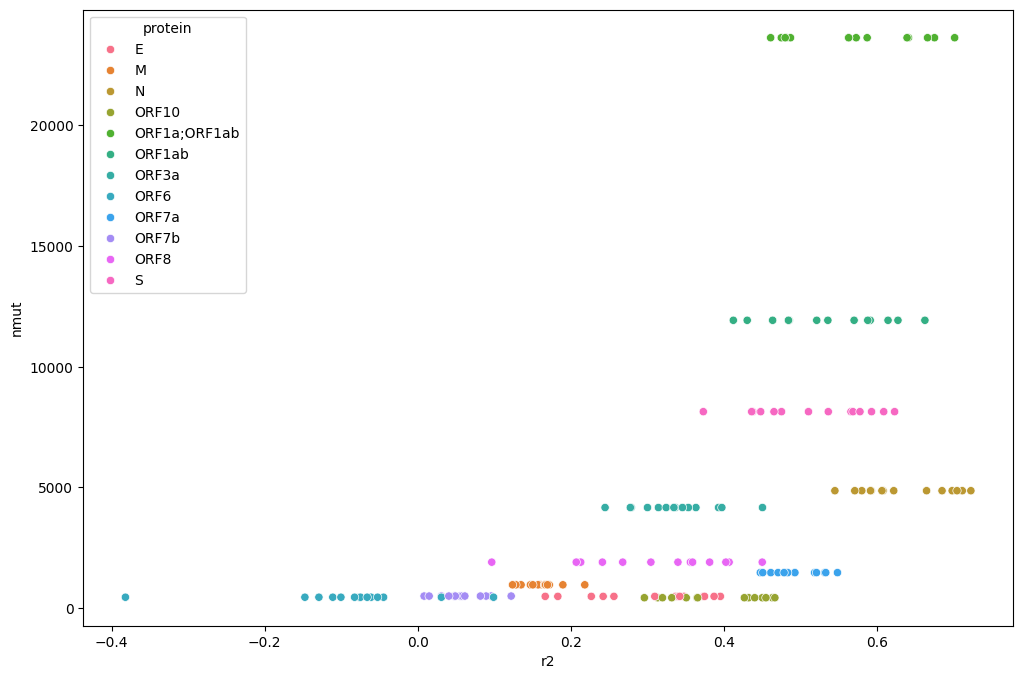

In [64]:
plt.figure(figsize=(12, 8))
sns.scatterplot(metrics_data_sized, x='r2', y='nmut', hue='protein')

<Axes: xlabel='protein', ylabel='r2'>

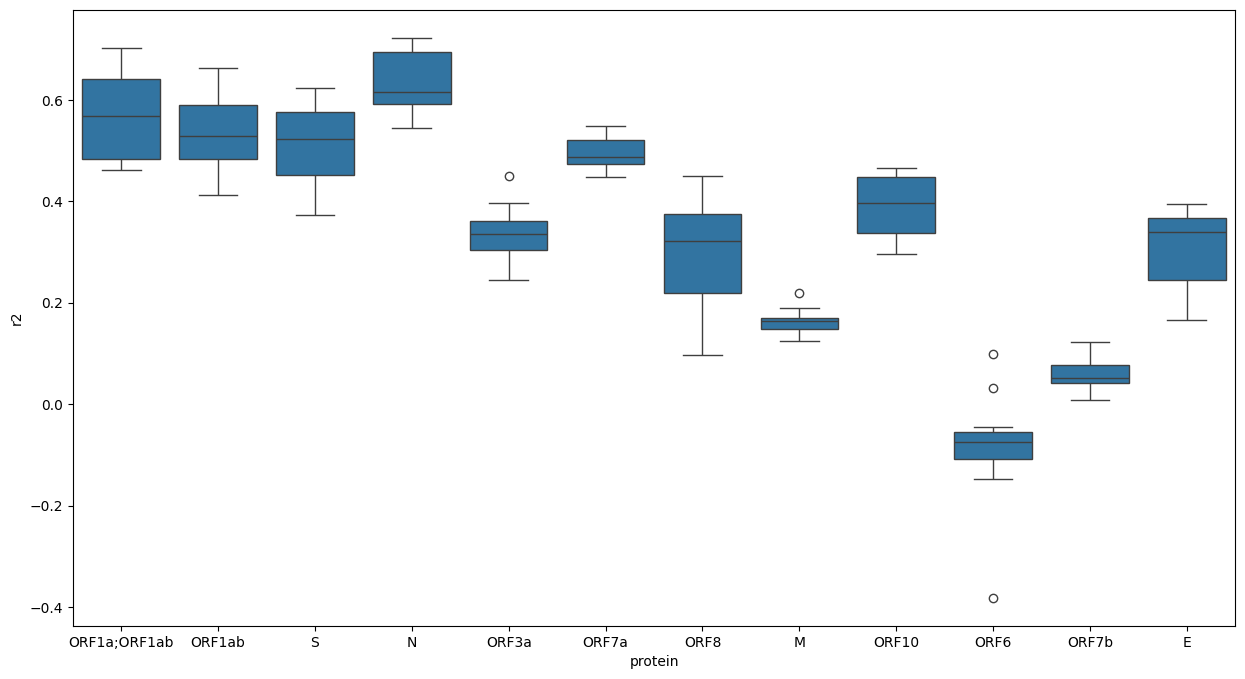

In [70]:
plt.figure(figsize=(15, 8))
sns.boxplot(metrics_data, x='protein', y='r2',
            # order=['ORF1a;ORF1ab', 'ORF1ab', 'S', 'ORF3a', 'M', 'N'],
            order=obs_clade.groupby('protein')['count'].sum().sort_values(ascending=False).index,
)

### How many mutations required for unbiased resilt?

In [68]:
sdata_full = []
for (cur_clade, ), obs_clade in obs.groupby(['clade']):
    if cur_clade not in clades_spectra['clade'].values:
        continue
    spectrum_clade = clades_spectra[clades_spectra['clade'] == cur_clade]
    exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    
    obs_clade = obs_clade[(obs_clade.aa1 != '*') & (obs_clade.aa2 != '*')]

    exploded = []
    for _, x in obs_clade[['aa1', 'aa2', 'count']].iterrows():
        for _ in range(x['count']):
            exploded.append(x)
    exploded = pd.DataFrame(exploded).reset_index(drop=True)
    exploded['count'] = 1

    sdata = []
    for n in np.logspace(2, np.log10(len(exploded)-10), 100).astype(int):
        cur_sample = exploded.sample(n, replace=False)
        _aa_subst = prepare_aa_subst(cur_sample, exp_aa_subst, aa_freqs_total_dct)
        cor_res = spearmanr(_aa_subst['nobs_freqs'], _aa_subst['nexp_freqs'])
        r2 = r2_score(_aa_subst['nobs_freqs'], _aa_subst['nexp_freqs'])
        sdata.append([n, cor_res.correlation, r2])

    sdata = pd.DataFrame(sdata, columns=['n', 'cor', 'r2']).assign(clade=cur_clade)
    sdata_full.append(sdata)


sdata_full_df = pd.concat(sdata_full)
sdata_full_df

,n,cor,r2,clade
0,100,0.472110,0.330910,20A
1,106,0.536463,0.389653,20A
2,113,0.481192,0.276265,20A
3,121,0.543176,0.485366,20A
4,129,0.473410,0.128456,20A
...,...,...,...,...
95,43245,0.786559,0.674945,22C
96,46098,0.792050,0.677014,22C
97,49140,0.789173,0.672573,22C
98,52382,0.792079,0.672765,22C


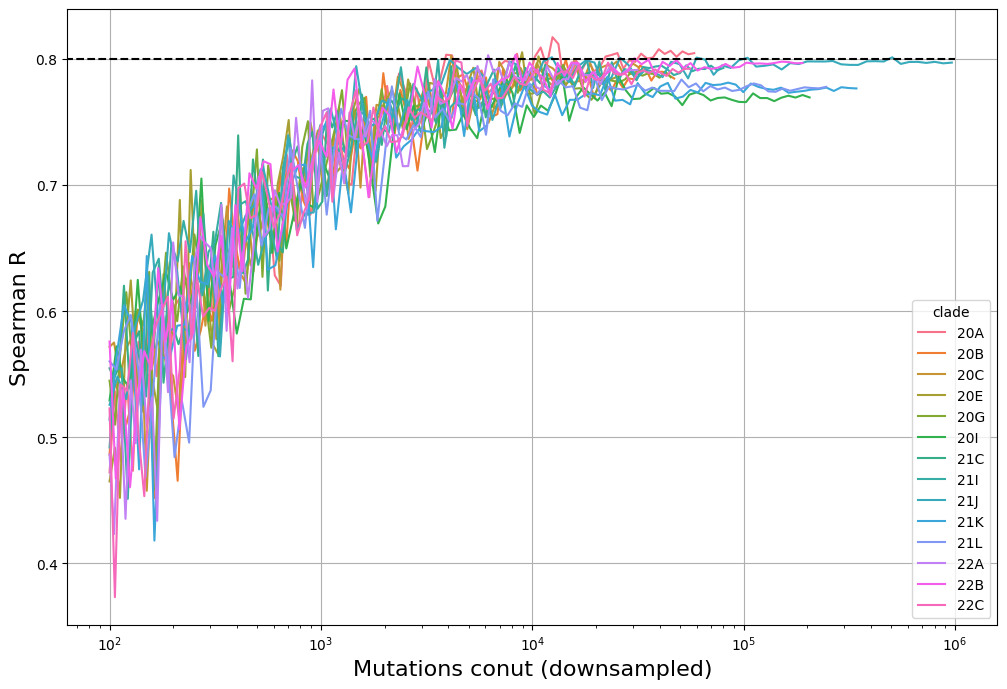

In [96]:
plt.figure(figsize=(12, 8))
sns.lineplot(sdata_full_df, x='n', y='cor', hue='clade')
plt.hlines(0.8, 0, 10**6, 'k', '--')
plt.grid()
plt.ylabel('Spearman R', fontsize=16)
plt.xlabel('Mutations conut (downsampled)', fontsize=16)
plt.xscale('log')

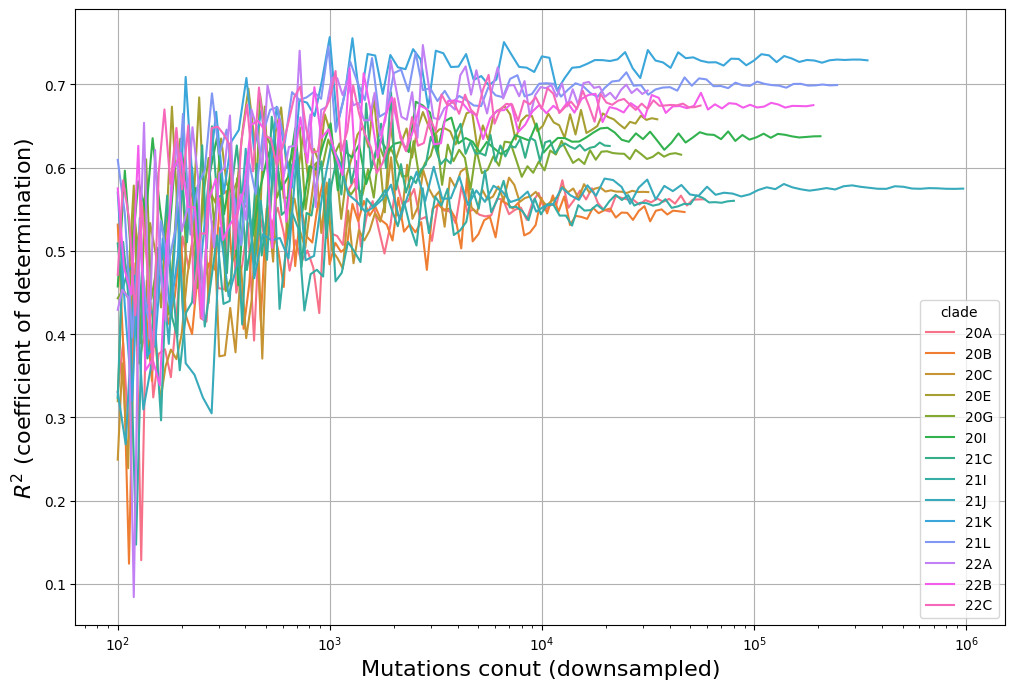

In [95]:
plt.figure(figsize=(12, 8))
sns.lineplot(sdata_full_df, x='n', y='r2', hue='clade')
# plt.hlines(0.63, 0, 10**6, 'k', '--')
plt.grid()
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Mutations conut (downsampled)', fontsize=16)
plt.xscale('log')

## Clade specific analysis VIZ

In [75]:
metrics_total_df = pd.read_csv('data/clades_fit_metrics.csv')\
    .set_index(['clade', 'sites_sample', 'sample_cutoff'])
metrics_total_df

r2      mape      wape     slope  \
clade sites_sample   sample_cutoff                                           
20A   total          10             0.562050  0.975288  0.571044  0.700099   
      most variable  10             0.313133  4.286220  0.783244  0.580131   
      least variable 10            -1.451300  1.590950  1.069770  0.357047   
      random         10             0.546182  1.362770  0.610896  0.685941   
      most variable  20             0.439350  2.348940  0.681967  0.683030   
...                                      ...       ...       ...       ...   
22C   least variable 20            -1.574000  1.616650  0.981694  0.547652   
      random         20             0.739695  2.433300  0.499723  0.786261   
      most variable  30             0.603442  2.087630  0.613345  0.748289   
      least variable 30            -1.621700  1.340780  0.970092  0.535600   
      random         30             0.676607  1.266560  0.545239  0.766002   

                                    intercept  spearman_corr    spearman_p  \
clade sites_sample   sample_cutoff                                           
20A   total          10              0.001999       0.804557  2.605530e-35   
      most variable  10              0.002799       0.675445  2.535340e-21   
      least variable 10              0.004286       0.494048  1.320710e-10   
      random         10              0.002094       0.762436  8.954080e-30   
      most variable  20              0.002113       0.723936  1.233250e-25   
...                                       ...            ...           ...   
22C   least variable 20              0.003016       0.596996  7.454560e-16   
      random         20              0.001425       0.755712  5.368510e-29   
      most variable  30              0.001678       0.750062  2.313630e-28   
      least variable 30              0.003096       0.586740  3.021540e-15   
      random         30              0.001560       0.784624  1.551150e-32   

                                    pearson_corr     pearson_p   ks_stat  \
clade sites_sample   sample_cutoff                                         
20A   total          10                 0.764714  4.814520e-30  0.140000   
      most variable  10                 0.630306  5.501780e-18  0.266667   
      least variable 10                 0.242637  2.774630e-03  0.260000   
      random         10                 0.754876  6.681090e-29  0.160000   
      most variable  20                 0.709525  2.918150e-24  0.166667   
...                                          ...           ...       ...   
22C   least variable 20                 0.335201  2.753230e-05  0.186667   
      random         20                 0.861568  2.006460e-45  0.106667   
      most variable  30                 0.791791  1.690270e-33  0.146667   
      least variable 30                 0.326385  4.578800e-05  0.206667   
      random         30                 0.828221  4.727050e-39  0.093333   

                                        ks_p      rmse  log_likelihood  \
clade sites_sample   sample_cutoff                                       
20A   total          10             0.105738  0.008080        -5.37518   
      most variable  10             0.000042  0.010065        -5.50504   
      least variable 10             0.000073  0.011893        -6.43311   
      random         10             0.042832  0.008287        -5.38897   
      most variable  20             0.030839  0.008694        -5.44079   
...                                      ...       ...             ...   
22C   least variable 20             0.010603  0.011222        -6.24236   
      random         20             0.361727  0.006389        -5.26546   
      most variable  30             0.079310  0.007615        -5.36479   
      least variable 30             0.003221  0.011276        -6.25164   
      random         30             0.532187  0.007027        -5.33119   

                                    mut_count  
clade sites_

In [76]:
metrics_total_df.reset_index().query('sites_sample == "total"')\
    .set_index('clade')[['r2','slope', 'spearman_corr', 'mut_count']].round(2)

,r2,slope,spearman_corr,mut_count
clade,,,,
20A,0.56,0.70,0.80,58390
20B,0.55,0.71,0.79,46932
20C,0.57,0.71,0.79,31691
20E,0.66,0.72,0.79,34924
20G,0.62,0.71,0.79,45231
20I,0.64,0.71,0.77,205188
21C,0.63,0.72,0.79,20840
21I,0.56,0.70,0.79,80214
21J,0.57,0.70,0.80,965925


In [ ]:
metrics_total_df.query('sites_sample == "total"').r2.mean()

np.float64(0.6302876428571428)

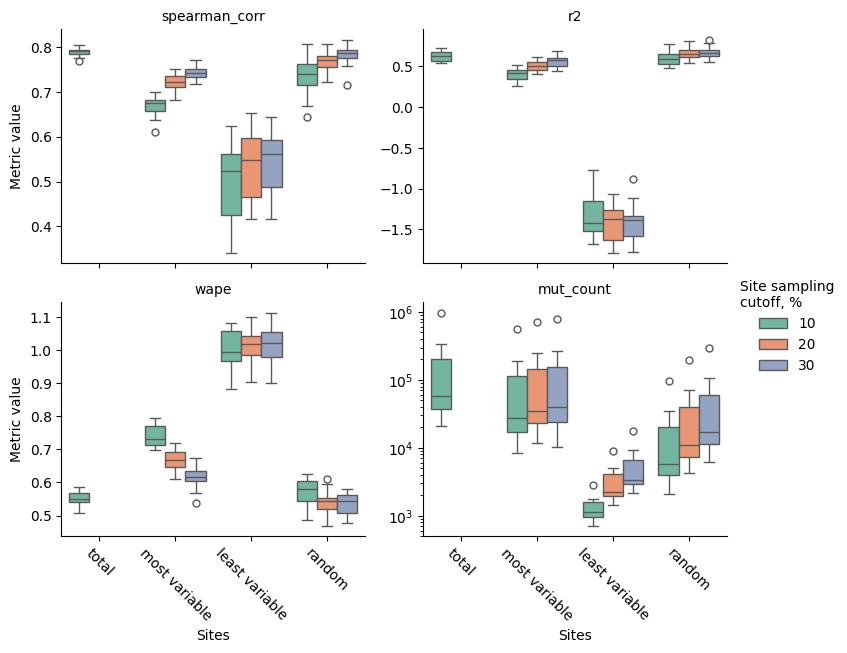

In [77]:
_ = metrics_total_df[['spearman_corr','r2', 'wape', 'mut_count']]\
    .melt(ignore_index=False, var_name='metric').reset_index()
g = sns.catplot(data=_, sharey=False, kind='box', col='metric', col_wrap=2,
                y='value', x='sites_sample', hue='sample_cutoff',  
                palette='Set2', height=3, aspect=1.25,
                # col_order=['accuracy']
)
g.set_titles('{col_name}')
g.set_xticklabels(g.axes[2].get_xticklabels(), rotation=-45)
g.set_xlabels('Sites')
g.set_ylabels('Metric value')
g.axes_dict['mut_count'].set_yscale('log')
g.legend.set_title('Site sampling\ncutoff, %')
g.savefig('./figures/clades_fit_metrics_boxplots.pdf')

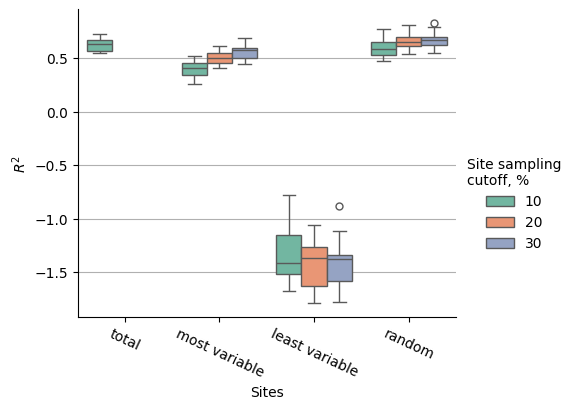

In [90]:
# _ = metrics_total_df[['spearman_corr','r2']]\
_ = metrics_total_df[['r2']]\
    .melt(ignore_index=False, var_name='metric').reset_index()
g = sns.catplot(data=_, sharey=False, kind='box', col='metric', col_wrap=1,
                y='value', x='sites_sample', hue='sample_cutoff',  
                palette='Set2', height=4, aspect=1.2,
                # col_order=['accuracy']
)
g.set_titles('')
g.set_xticklabels(g.axes[0].get_xticklabels(), rotation=-25)
g.set_xlabels('Sites')
g.set_ylabels('$R^2$')
g.legend.set_title('Site sampling\ncutoff, %')
plt.grid(axis='y')
# g.savefig('./figures/clades_fit_metrics_boxplots.pdf')

In [97]:
metrics_total_df.sort_values('mut_count').tail(10)

r2     mape      wape     slope  \
clade sites_sample  sample_cutoff                                          
20I   total         10             0.637814  2.25137  0.549044  0.707446   
21K   most variable 20             0.614205  2.27479  0.609977  0.755126   
21L   total         10             0.699340  1.29903  0.525485  0.763998   
21K   most variable 30             0.694608  1.43143  0.537568  0.776257   
21J   random        30             0.660727  1.27919  0.539698  0.681266   
21K   total         10             0.728994  1.23298  0.507370  0.796750   
21J   most variable 10             0.460142  9.83294  0.712744  0.589468   
                    20             0.502983  2.33992  0.648230  0.660417   
                    30             0.569669  1.64704  0.581933  0.709676   
      total         10             0.574873  1.24926  0.560137  0.704800   

                                   intercept  spearman_corr    spearman_p  \
clade sites_sample  sample_cutoff                                           
20I   total         10              0.001950       0.769494  1.279860e-30   
21K   most variable 20              0.001632       0.736816  6.128350e-27   
21L   total         10              0.001573       0.777879  1.157870e-31   
21K   most variable 30              0.001492       0.766069  3.318040e-30   
21J   random        30              0.002125       0.816787  3.546270e-37   
21K   total         10              0.001355       0.776622  1.671100e-31   
21J   most variable 10              0.002737       0.701084  1.704790e-23   
                    20              0.002264       0.744022  1.056750e-27   
                    30              0.001935       0.765176  4.242200e-30   
      total         10              0.001968       0.797127  3.064460e-34   

                                   pearson_corr     pearson_p   ks_stat  \
clade sites_sample  sample_cutoff                                         
20I   total         10                 0.802529  5.158430e-35  0.080000   
21K   most variable 20                 0.797727  2.521240e-34  0.146667   
21L   total         10                 0.839276  5.305810e-41  0.100000   
21K   most variable 30                 0.838080  8.764220e-41  0.113333   
21J   random        30                 0.813221  1.282630e-36  0.080000   
21K   total         10                 0.856916  1.934160e-44  0.093333   
21J   most variable 10                 0.695277  5.541710e-23  0.233333   
                    20                 0.730266  2.881710e-26  0.153333   
                    30                 0.769895  1.143650e-30  0.106667   
      total         10                 0.771425  7.427420e-31  0.086667   

                                       ks_p      rmse  log_likelihood  \
clade sites_sample  sample_cutoff                                       
20I   total         10             0.724957  0.007755        -5.29562   
21K   most variable 20             0.079310  0.007394        -5.38395   
21L   total         10             0.442524  0.006834        -5.34046   
21K   most variable 30             0.291074  0.006723        -5.33085   
21J   random        30             0.724957  0.007316        -5.27331   
21K   total         10             0.532187  0.006309        -5.35436   
21J   most variable 10             0.000541  0.009119        -5.32277   
                    20             0.058682  0.008203        -5.36821   
                    30             0.361727  0.007488        -5.36965   
      total         10             0.627917  0.007509        -5.40139   

                                   mut_count  
clade sites_sample  sample_cutoff             
20I   total         10                205188  
21K   most variable 20                245557  
21L   total         10                245921  
21K   most variable 30                267402  
21J   random        30                297378  
21K   total         10                341745  
21J   most variable 10                562461  
  

## Random model on clades 

In [98]:
metrics_rnd_df = pd.read_csv('data/rnd_fit_metrics.csv', index_col=[0,1,2])
metrics_rnd_df

r2      mape      wape     slope  intercept  \
model   clade replica                                                      
neutral 20A   1        0.562050  0.975288  0.571044  0.700099   0.001999   
random  20A   1       -0.033205  4.248530  1.071910  0.039748   0.006402   
              2        0.104252  4.745880  0.972451  0.126301   0.005825   
              3       -0.063253  6.100200  1.136530  0.042976   0.006380   
              4       -0.146898  5.389780  1.096080 -0.009530   0.006730   
...                         ...       ...       ...       ...        ...   
        22C   16      -0.132896  6.364780  1.108570  0.012824   0.006581   
              17      -0.137233  4.133840  1.036580  0.002072   0.006653   
              18      -0.030338  7.879650  1.175490  0.058693   0.006275   
              19       0.125539  5.255980  1.033300  0.175919   0.005494   
              20      -0.033376  5.484550  1.005130  0.070099   0.006199   

                       spearman_corr    spearman_p  pearson_corr  \
model   clade replica                                              
neutral 20A   1             0.804557  2.605530e-35      0.764714   
random  20A   1             0.250861  1.959060e-03      0.118400   
              2             0.391814  7.111740e-07      0.327916   
              3             0.034170  6.780580e-01      0.111259   
              4             0.144503  7.768890e-02     -0.026655   
...                              ...           ...           ...   
        22C   16            0.143614  7.955150e-02      0.032206   
              17            0.386010  1.068840e-06      0.005512   
              18            0.001673  9.837860e-01      0.152707   
              19            0.227990  5.016180e-03      0.369804   
              20            0.345038  1.532020e-05      0.168255   

                          pearson_p   ks_stat          ks_p      rmse  \
model   clade replica                                                   
neutral 20A   1        4.814520e-30  0.140000  1.057380e-01  0.008080   
random  20A   1        1.490060e-01  0.426667  1.248880e-12  0.012411   
              2        4.196320e-05  0.346667  2.162780e-08  0.011556   
              3        1.752730e-01  0.386667  2.176880e-10  0.012590   
              4        7.461040e-01  0.380000  4.868720e-10  0.013076   
...                             ...       ...           ...       ...   
        22C   16       6.956170e-01  0.366667  2.324880e-09  0.013559   
              17       9.466290e-01  0.293333  4.284920e-06  0.013585   
              18       6.210000e-02  0.333333  8.870020e-08  0.012931   
              19       3.201380e-06  0.240000  3.347340e-04  0.011912   
              20       3.957490e-02  0.306667  1.247810e-06  0.012950   

                       log_likelihood  mut_count  
model   clade replica                             
neutral 20A   1              -5.37518      58390  
random  20A   1              -6.00508      58390  
              2              -5.80847      58390  
              3              -6.04659      58390  
              4              -6.25771      58390  
...                               ...        ...  
        22C   16             -6.12582      55848  
              17             -6.20743      55848  
              18             -6.21365      55848  
              19             -5.89037      55848  
              20             -5.93558      55848  

[294 rows x 14 columns]

/tmp/ipykernel_112608/624859558.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=_, sharey=False, kind='box', col='metric',


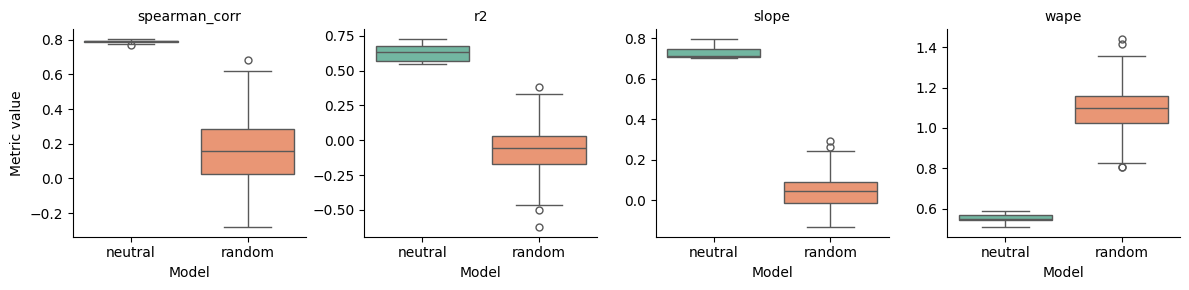

In [99]:
_ = metrics_rnd_df[['spearman_corr', 'r2', 'slope', 'wape']]\
    .melt(ignore_index=False, var_name='metric').reset_index()
g = sns.catplot(data=_, sharey=False, kind='box', col='metric', 
                y='value', x='model', palette='Set2', height=3, aspect=1,
)
g.set_titles('{col_name}')
# g.set_xticklabels(g.axes[2].get_xticklabels(), rotation=-45)
g.set_xlabels('Model')
g.set_ylabels('Metric value')
g.savefig('./figures/rnd_fit_metrics_boxplots.pdf')


In [100]:
metrics_rnd_df

r2      mape      wape     slope  intercept  \
model   clade replica                                                      
neutral 20A   1        0.562050  0.975288  0.571044  0.700099   0.001999   
random  20A   1       -0.033205  4.248530  1.071910  0.039748   0.006402   
              2        0.104252  4.745880  0.972451  0.126301   0.005825   
              3       -0.063253  6.100200  1.136530  0.042976   0.006380   
              4       -0.146898  5.389780  1.096080 -0.009530   0.006730   
...                         ...       ...       ...       ...        ...   
        22C   16      -0.132896  6.364780  1.108570  0.012824   0.006581   
              17      -0.137233  4.133840  1.036580  0.002072   0.006653   
              18      -0.030338  7.879650  1.175490  0.058693   0.006275   
              19       0.125539  5.255980  1.033300  0.175919   0.005494   
              20      -0.033376  5.484550  1.005130  0.070099   0.006199   

                       spearman_corr    spearman_p  pearson_corr  \
model   clade replica                                              
neutral 20A   1             0.804557  2.605530e-35      0.764714   
random  20A   1             0.250861  1.959060e-03      0.118400   
              2             0.391814  7.111740e-07      0.327916   
              3             0.034170  6.780580e-01      0.111259   
              4             0.144503  7.768890e-02     -0.026655   
...                              ...           ...           ...   
        22C   16            0.143614  7.955150e-02      0.032206   
              17            0.386010  1.068840e-06      0.005512   
              18            0.001673  9.837860e-01      0.152707   
              19            0.227990  5.016180e-03      0.369804   
              20            0.345038  1.532020e-05      0.168255   

                          pearson_p   ks_stat          ks_p      rmse  \
model   clade replica                                                   
neutral 20A   1        4.814520e-30  0.140000  1.057380e-01  0.008080   
random  20A   1        1.490060e-01  0.426667  1.248880e-12  0.012411   
              2        4.196320e-05  0.346667  2.162780e-08  0.011556   
              3        1.752730e-01  0.386667  2.176880e-10  0.012590   
              4        7.461040e-01  0.380000  4.868720e-10  0.013076   
...                             ...       ...           ...       ...   
        22C   16       6.956170e-01  0.366667  2.324880e-09  0.013559   
              17       9.466290e-01  0.293333  4.284920e-06  0.013585   
              18       6.210000e-02  0.333333  8.870020e-08  0.012931   
              19       3.201380e-06  0.240000  3.347340e-04  0.011912   
              20       3.957490e-02  0.306667  1.247810e-06  0.012950   

                       log_likelihood  mut_count  
model   clade replica                             
neutral 20A   1              -5.37518      58390  
random  20A   1              -6.00508      58390  
              2              -5.80847      58390  
              3              -6.04659      58390  
              4              -6.25771      58390  
...                               ...        ...  
        22C   16             -6.12582      55848  
              17             -6.20743      55848  
              18             -6.21365      55848  
              19             -5.89037      55848  
              20             -5.93558      55848  

[294 rows x 14 columns]

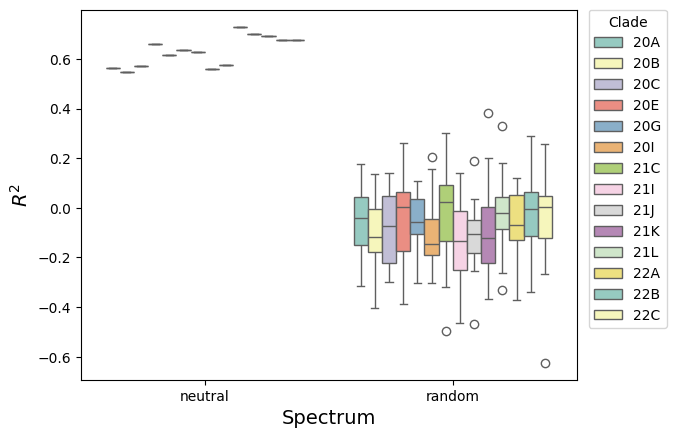

In [115]:
_ = metrics_rnd_df[['spearman_corr', 'r2', 'slope', 'wape']]
ax = sns.boxplot(data=metrics_rnd_df.reset_index(), 
                y='r2', x='model', hue='clade',
                palette='Set3',
)
ax.set_xlabel('Spectrum', fontsize=14)
ax.set_ylabel('$R^2$', fontsize=14)
plt.legend(title='Clade', bbox_to_anchor=(1.01, 1.02), loc='upper left')
# g.savefig('./figures/rnd_fit_metrics_boxplots.pdf')